# Finesse Tutorial: Investigating the effect of output mode cleaner on quantum noise limited snesitvity
Enzo Tapia, Alina Soflau, Yashwant Bothra, Andreas Freise, 

Nikhef, 14.10.2025

This notebook was used in the IMPRS School "Gravity at the Extreme: from Theory to Observation"< October 2025>

# Sensitivity of Advanced Gravitational-Wave Detectors

In this notebook we will work with plots similar to the famous sensitivity curves of detectors like Advanced LIGO and Advanced Virgo. Our results will not be identical to the official ones, but they will illustrate the main steps involved in computing detector sensitivity and understanding the role of the Output Mode Cleaner (OMC).

**We will**:

* Review why RF sidebands are used in gravitational-wave detectors.
* Review what an Output Mode Cleaner (OMC) does.
* Implement and analyze a 4-mirror bow-tie OMC.
* Get its Free Spectral Range (FSR), finesse, and linewidth.
* Examine how the OMC transmits the carrier while rejecting higher-order modes and RF sidebands.

**After this notebook you will be able to**:
* Compute frequency noise for a detector with RF sidebands.
* See how the OMC affects the detector’s quantum noise–limited sensitivity.
* Read and interpret a sensitivity curve.
  
**This notebook assumes you already know**: (from the first notebook presented by Andreas)

* What a transfer function is
* What a signal-to-noise ratio means
* What amplitude and power spectral densities are
* How to run and create Finesse 3 models
* How to compute the response of a GW detector to gravitational-wave signals

In [4]:
# install pypi wheel only on google colab
!env | grep -q 'colab' && pip install finesse || echo 'Not on google colab, assuming finesse already installed'

Not on google colab, assuming finesse already installed


In [1]:
import matplotlib.pyplot as plt
import numpy as np

import finesse.analysis.actions as faa

import finesse
from finesse.analysis.actions import Xaxis
finesse.init_plotting()

## Why do we need RF sidebands?
In gravitational-wave detectors like **LIGO** and **Virgo**, the main laser light (called the carrier) is kept on a dark fringe at the interferometer output so that tiny differential arm length changes caused by gravitational waves can be detected as variations in the light power. However, since the carrier is almost entirely suppressed at the output, we need a way to extract information about these changes and control the interferometer. This is achieved by adding radio-frequency (RF) sidebands to the laser beam using an electro-optic modulator (EOM).
The RF sidebands serve for generating error signals that keep the interferometer cavities properly aligned and resonant. They do not resonate in the arm cavities in the same way as the carrier, allowing them to carry out control and sensing functions without interfering with the gravitational-wave signal.


## What is an OMC?

In an interferometer, the Output Mode Cleaner (OMC) ensures that only the fundamental $TEM_{00}$ carrier light reaches the detection photodiode.  
It:
- Removes higher-order spatial modes (HOMs), and  
- Suppresses the radio-frequency (RF) sidebands (here, 9.099 MHz).

To achieve this, the OMC is a **small, high-finesse optical cavity**, typically in a **bow-tie geometry** to separate counter-propagating beams and avoid unwanted interference.

## Task 1.

* On a piece of paper make a sketch of a bow-tie optical cavity configuration.
* Using the given parameters, complete the code of the following cell to implement a bow-tie optical cavity  OMC.
* Using the ```plot_graph()``` command in Finesse, show an sketch of the implemented OMC. Compare with your sketch.
* Using the cavity object, obtain the cavity's free spectral range, cavity pole and finesse.
* Scan the tuning of the BS "OMC_2" to produce a free spectral range scan of the cavity.
* Compute a transfer function of amplitude noise of the laser input vs output of the OMC.

In [2]:
nsilica = 1.44963
T1 = 0.00285
T2 = 0.0075
T3 = 36.0e-6
T4 = 35.9e-6

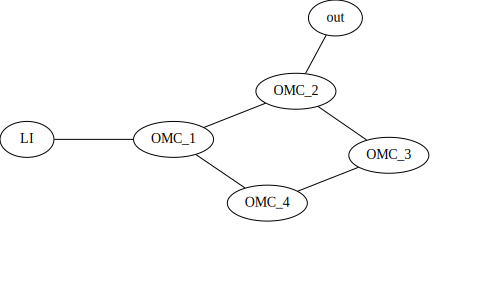

In [3]:
OMC_model = finesse.Model()
OMC_model.parse(f"""
l LI P=125
s s0 LI.p1 OMC_1.p1 L=1
# OMC
bs OMC_1 T= L=0 alpha=2.7609
s sOMC_1 OMC_1.p3 OMC_2.p1 L=0.2815 nr={nsilica}
bs OMC_2 T= L=0 alpha=2.7609
s sOMC_2 OMC_2.p2 OMC_3.p1 L=0.2842 nr={nsilica}
bs OMC_3 T= L=0 alpha=4.004 Rc=2.57321
s sOMC_3 OMC_3.p2 OMC_4.p1 L=0.2815 nr={nsilica}
bs OMC_4 T= L=0 alpha=4.004 Rc=2.57369
s sOMC_4 OMC_4.p2 OMC_1.p4 L=0.2842 nr={nsilica}
cavity cavOMC OMC_1.p3.o

s sout OMC_2.p3 out.p1
nothing out

## PDs:
pd trns_OMC2 out.p1.i
""")

## Plot graph

## Check round_trip_optical_length and compute FSR.

In [4]:
OMC_model.cavOMC.round_trip_optical_length

1.640111382

182914406.48023015

## Show the FSR, finesse and cavity pole.

Cavity FSR: 182787865.074 [Hz]
Cavity pole: 152065.369 [Hz]
Cavity finesse: 601.017


## Free spectral range scan and plot of the transmitted power.

Scan the tuning of the "OMC_2" and see the power at the output port.

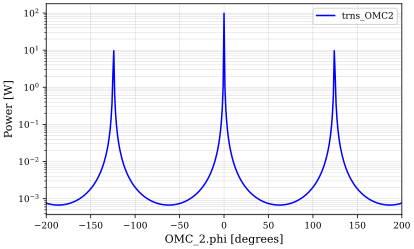

In [7]:
sim = OMC_model.run(faa.Xaxis("OMC_2.phi", 'lin', -2e2,2e2,400))
sim.plot(logy=True);

## Compute TF of the OMC to Laser amplitude noise.

In [2]:
def get_TF(base, input_node, output_node):
    ifo = base.deepcopy()
    ifo.parse(f"""
    fsig(1)
    sgen sig1 {input_node} 1 0
    pd1 TF {output_node} f=fsig.f
    """)
    return ifo.run(Xaxis('fsig.f', 'log', fstart, fstop, Npoints))

# specifying our frequency range for future use
fstart = 5
fstop = 1e6
Npoints = 200

In [ ]:
## TF.

## Task 2:
Two interferometer models are provided. One without an OMC (```ifo_base```) and one with RF sidebands and an OMC (```ifo_omc```).
* Perform a scan (tuning) of the bs1 and compare the power at different ports of both models. Explain the power level seen at these ports at 0 tuning. Repeat for tuning of the "OMC_2".
* Implement amplitude detectors to understand what is the content of the output port power.
* Compute the gravitational wave signal transfer function to the output of a detector at the output port for each configuration. Explain the differences between the plots if any.

In [9]:
## A model of the full detector with RF sidebands (with an Electro Optic Modulator):
f9 = 9099055
m_idx = 0 # We start here with modulation index 0 to bypass the EOM.
ifo_base = finesse.Model()
ifo_base.parse(f""" 
l LI P=125
s s0 LI.p1 eom9.p1 L=1
mod eom9 f={f9} midx={m_idx}
s sEOM9 eom9.p2 PRM.p1 L=1

# Power recycling mirror
m PRM T=0.03 L=37.5u phi=90
s prc PRM.p2 bs1.p1 L=53

# Central beamsplitter
bs bs1 R=0.5 T=0.5 phi=0 alpha=45

# X-arm
s sx bs1.p3 ITMX.p1 L=4.5
m ITMX T=0.014 L=37.5u phi=89.997
s Lx ITMX.p2 ETMX.p1 L=3995
m ETMX T=0 L=37.5u phi=89.997

# Y-arm
s sy bs1.p2 ITMY.p1 L=4.45
m ITMY T=0.014 L=37.5u phi=3m
s Ly ITMY.p2 ETMY.p1 L=3995
m ETMY T=0 L=37.5u phi=3m

# Signal recycling mirror
s src bs1.p4 SRM.p1 L=50.525
m SRM T=0.2 L=37.5u phi=-90

# These commands give the mirrors a mass
# by default they are infinitely heavy
free_mass ITMX_sus ITMX.mech mass=40
free_mass ETMX_sus ETMX.mech mass=40
free_mass ITMY_sus ITMY.mech mass=40
free_mass ETMY_sus ETMY.mech mass=40

## PDs:
pd circ_PRM PRM.p2.o
pd circ_SRM SRM.p1.o
pd trns_SRM SRM.p2.o
""") 

In [10]:
ifo_base.eom9.midx

<eom9.midx=0.0 @ 0x15ab73340>

## Adding an OMC and a PD in transmission of the OMC.

In [11]:
ifo_omc = ifo_base.deepcopy()
ifo_omc.eom9.midx = 0.135 # We set the modulation index of the EOM.
ifo_omc.parse(f""" 
s sSRM_OMC SRM.p2 OMC_1.p1 L=1
# OMC
# OMC goes here.

## PDs:
pd trns_OMC OMC_2.p3.o # Main output is the OMC_2.
""") 

## Comparison of the scan of BS1 for a model with and without an OMC.

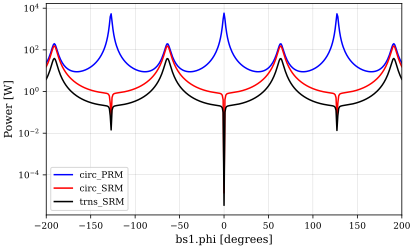

In [12]:
sim = ifo_base.run(faa.Xaxis("bs1.phi", 'lin', -2e2,2e2,400))
sim.plot(logy=True);

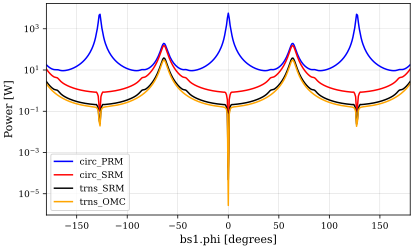

In [13]:
sim_omc = ifo_omc.run(faa.Xaxis("bs1.phi", 'lin', -180,180,400))
sim_omc.plot(logy=True);

## Explain the differences between these two plots.

## Tuning now the OMC_2 and checking the power at the output.

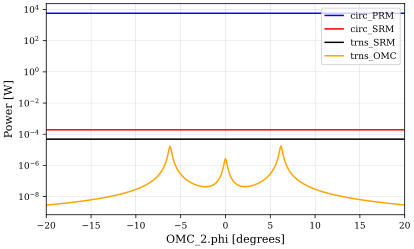

## Adding new amplitude detectors to explain the signals seen

In [3]:
ifo_omc_ads = ifo_omc.deepcopy()

ifo_omc_ads.parse(f""" 
## ADs
ad ad_SRM_USB_9 node=SRM.p2.o f={f9}
ad ad_SRM_LSB_9 node=SRM.p2.o f={-f9}
ad ad_SRM_CAR node=SRM.p2.o f={0}

# Add here Amplitude detectors at the output port of the OMC.
""") 

NameError: name 'ifo_omc' is not defined

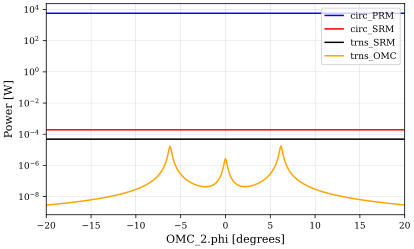

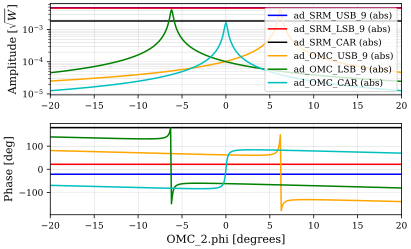

In [16]:
sim = ifo_omc_ads.run(faa.Xaxis("OMC_2.phi", 'lin', -20,20,400))
sim.plot(logy=True);

## Discuss and explain what this plot shows and means.

## Explain transmitted power after the SRM mirror and after the OMC (OMC_2):

Text(0, 0.5, 'Power [W]')

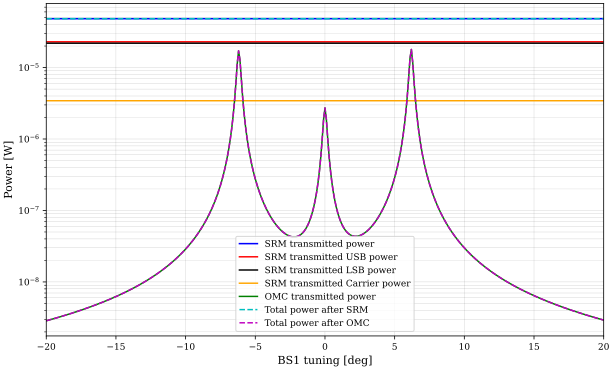

In [17]:
lsb_pwr_srm = np.abs(sim['ad_SRM_LSB_9'])**2
usb_pwr_srm = np.abs(sim['ad_SRM_USB_9'])**2
car_pwr_srm = np.abs(sim['ad_SRM_CAR'])**2

total_pwr_srm = car_pwr_srm + lsb_pwr_srm + usb_pwr_srm

# Compute here the total power at the output port of the OMC in the same way.

plt.figure(figsize =(10,6))
plt.semilogy(sim.x1, np.abs(sim['trns_SRM']), label = 'SRM transmitted power')
plt.semilogy(sim.x1, np.abs(sim['ad_SRM_USB_9'])**2, label = 'SRM transmitted USB power')
plt.semilogy(sim.x1, np.abs(sim['ad_SRM_LSB_9'])**2, label = 'SRM transmitted LSB power')
plt.semilogy(sim.x1, np.abs(sim['ad_SRM_CAR'])**2, label = 'SRM transmitted Carrier power')
plt.semilogy(sim.x1, np.abs(sim['trns_OMC']), '-', label = 'OMC transmitted power')
plt.semilogy(sim.x1, total_pwr_srm, '--', label = 'Total power after SRM')
plt.semilogy(sim.x1, total_pwr_omc, '--', label = 'Total power after OMC')
plt.legend()
plt.xlabel("BS1 tuning [deg]")
plt.ylabel("Power [W]")

## Compute the GW signal TF for each configuration:

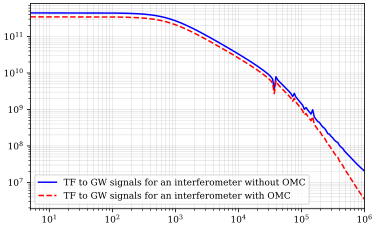

In [18]:
# Here we add our new code to compute a transfer function
ifo_base.parse(f"""
fsig(1)

sgen sig1 Ly.h 1 0
sgen sig2 Lx.h 1 180

pd1 TF SRM.p2.o f=fsig.f
""")

# Here we add our new code to compute a transfer function
# Note that here you need to put it at the output of the OMC.

out1 = ifo_base.run(Xaxis('fsig.f', 'log', fstart, fstop, Npoints))
#out2 = ifo_omc.run(Xaxis('fsig.f', 'log', fstart, fstop, Npoints))
    
# We store the frequency and magnitude of the transfer function [W/h]
# (In general we need to store the magnitude and phase of the transfer 
# functions but we only need the magniture for these examples.)
f, Hs_ifo_base = out1.x1, np.abs(out1['TF'])
#f, Hs_ifo_omc = out2.x1, np.abs(out2['TF'])

plt.loglog(f, Hs_ifo_base, label = 'TF to GW signals for an interferometer without OMC')
#plt.loglog(f, Hs_ifo_omc, '--', label = 'TF to GW signals for an interferometer with OMC')
plt.legend()
plt.show()

## Task 3 
* Compute and compare the Quantum noise limit sensitivity (QNLS) for an interferometer with and without RF sidebands and OMC. Explain the differences if any.

In [ ]:
## Write the code here to compute the QNLS and plot it.